# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps

import random
import time

#import any other library you need below this line

#Loading data

Upload the data in zip format to Colab. Then run the cell below.

In [ ]:
!unzip data.zip

#Defining the Dataset Class

In [66]:
class Cell_data(Dataset):
  def __init__(self, data_dir, size, train = 'True', train_test_split = 0.8, augment_data = True):
    ##########################inputs##################################
    #data_dir(string) - directory of the data#########################
    #size(int) - size of the images you want to use###################
    #train(boolean) - train data or test data#########################
    #train_test_split(float) - the portion of the data for training###
    #augment_data(boolean) - use data augmentation or not#############
    super(Cell_data, self).__init__()
    # todo
    #initialize the data class
    self.augment_data = augment_data

    self.images_dir = os.path.join(data_dir, 'scans')
    self.labels_dir = os.path.join(data_dir, 'labels')
    self.images = os.listdir(self.images_dir)
    self.labels = os.listdir(self.labels_dir)

    length = len(self.images)
    split = int(train_test_split*length)
    data_idxStart = 0
    data_idxEnd = 0
    if train:
      data_idxStart = 0
      data_idxEnd = split
    else:
      data_idxStart = split
      data_idxEnd = length
    self.image_data = []
    self.label_data = []
    for idx in range(data_idxEnd - data_idxStart):
      self.image_data.append(os.path.join(self.images_dir, self.images[idx + data_idxStart]))
      self.label_data.append(os.path.join(self.labels_dir, self.labels[idx + data_idxStart]))

    self.image_trans = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()]
    )
    self.label_trans = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.PILToTensor()]
    )


  def __getitem__(self, idx):
    # todo

    #load image and mask from index idx of your data
    # img = Image.open(self.images_dir + self.images[idx])
    # lab = Image.open(self.labels_dir + self.labels[idx])
    img = Image.open(self.image_data[idx])
    lab = Image.open(self.label_data[idx])


    #data augmentation part
    if self.augment_data:
      augment_mode = np.random.randint(0, 4)
      if augment_mode == 0:
        #todo 
        #flip image vertically
        img = transforms.RandomVerticalFlip(p=1)(img)
        lab = transforms.RandomVerticalFlip(p=1)(lab)
      elif augment_mode == 1:
        #todo
        #flip image horizontally
        img = transforms.RandomHorizontalFlip(p=1)(img)
        lab = transforms.RandomHorizontalFlip(p=1)(lab)
      elif augment_mode == 2:
        #todo
        #zoom image
        randomNum = np.random.randint(2,7)
        img = ImageOps.crop(img, img.size[0] // randomNum)
        lab = ImageOps.crop(lab, lab.size[0] // randomNum)
      else:
        #todo 
        #rotate image
        img = img.transpose(Image.ROTATE_90)
        lab = lab.transpose(Image.ROTATE_90)

    image = self.image_trans(img)
    label = self.label_trans(lab)

    #image = image.squeeze(0)
    #label = label.squeeze(0)
    #todo
    #return image and mask in tensors
    return image, label
      
      
      

  def __len__(self):
    return len(self.image_data)


#Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [4]:
class twoConvBlock(nn.Module):
  def __init__(self, input_ch, output_ch):
    super(twoConvBlock, self).__init__()
    #todo
    #initialize the block
    self.layer = nn.Sequential(
        nn.Conv2d(input_ch, output_ch, 3),
        nn.ReLU(),
        nn.Conv2d(output_ch, output_ch, 3),
        nn.BatchNorm2d(output_ch),
        nn.ReLU()
    )

  def forward(self, x):
    #todo
    #implement the forward path
    z = self.layer(x)
    return z

class downStep(nn.Module):
  def __init__(self):
    super(downStep, self).__init__()
    #todo
    #initialize the down path
    # self.layer = nn.Sequential(
    #     nn.MaxPool2d(2),
    # )
    self.layer = nn.MaxPool2d(2, 2)

  def forward(self, x):
    #todo
    #implement the forward path
    z = self.layer(x)
    return z

class upStep(nn.Module):
  def __init__(self, input_ch, output_ch):
    super(upStep, self).__init__()
    #todo
    #initialize the up path
    self.conv = nn.ConvTranspose2d(input_ch, output_ch, 2, 2)

  def forward(self, x, prev_x):
    #todo
    #implement the forward path
    z = self.conv(x)

    crop_rows = (prev_x.shape[2] - z.shape[2]) // 2
    crop_cols = (prev_x.shape[3] - z.shape[3]) // 2
    prev_x = prev_x[:, :, crop_rows:(crop_rows + z.shape[2]), crop_cols:(crop_cols + z.shape[3])]
    z = torch.cat((prev_x, z), 1)

    return z

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    #todo
    #initialize the complete model
    self.conv1 = twoConvBlock(1, 64)
    self.conv2 = twoConvBlock(64, 128)
    self.conv3 = twoConvBlock(128, 256)
    self.conv4 = twoConvBlock(256, 512)
    self.conv5 = twoConvBlock(512, 1024)

    self.down = downStep()
    self.up1 = upStep(1024, 512)
    self.up2 = upStep(512, 256)
    self.up3 = upStep(256, 128)
    self.up4 = upStep(128, 64)

    self.riconv1 = twoConvBlock(1024, 512)
    self.riconv2 = twoConvBlock(512, 256)
    self.riconv3 = twoConvBlock(256, 128)
    self.riconv4 = twoConvBlock(128, 64)
    
    self.conv = nn.Conv2d(64, 2, 1)



  def forward(self, x):
    #todo
    #implement the forward path
    c1 = self.conv1(x)
    c2 = self.down(c1)
    c2 = self.conv2(c2)
    c3 = self.down(c2)
    c3 = self.conv3(c3)
    c4 = self.down(c3)
    c4 = self.conv4(c4)
    c5 = self.down(c4)
    c5 = self.conv5(c5)
    #print(c5.shape[1])

    ric1 = self.up1(c5, c4)
    ric1 = self.riconv1(ric1)
    ric2 = self.up2(ric1, c3)
    ric2 = self.riconv2(ric2)
    ric3 = self.up3(ric2, c2)
    ric3 = self.riconv3(ric3)
    ric4 = self.up4(ric3, c1)
    ric4 = self.riconv4(ric4)
    
    ric5 = self.conv(ric4)

    return ric5


#Training

Epoch 1 / 20 --- Loss: 0.1489
Accuracy: 0.5896 ---- Loss: 0.1541
Epoch 2 / 20 --- Loss: 0.1468
Accuracy: 0.6211 ---- Loss: 0.1614
Epoch 3 / 20 --- Loss: 0.1554
Accuracy: 0.6379 ---- Loss: 0.1428
Epoch 4 / 20 --- Loss: 0.1628
Accuracy: 0.8472 ---- Loss: 0.1297
Epoch 5 / 20 --- Loss: 0.1794
Accuracy: 0.8133 ---- Loss: 0.1215
Epoch 6 / 20 --- Loss: 0.1656
Accuracy: 0.6357 ---- Loss: 0.1481
Epoch 7 / 20 --- Loss: 0.1634
Accuracy: 0.7551 ---- Loss: 0.1259
Epoch 8 / 20 --- Loss: 0.1545
Accuracy: 0.7205 ---- Loss: 0.1395
Epoch 9 / 20 --- Loss: 0.1812
Accuracy: 0.7917 ---- Loss: 0.1433
Epoch 10 / 20 --- Loss: 0.1819
Accuracy: 0.3262 ---- Loss: 0.2138
Epoch 11 / 20 --- Loss: 0.1615
Accuracy: 0.7424 ---- Loss: 0.1736
Epoch 12 / 20 --- Loss: 0.1467
Accuracy: 0.6858 ---- Loss: 0.4040
Epoch 13 / 20 --- Loss: 0.2084
Accuracy: 0.5334 ---- Loss: 0.2888
Epoch 14 / 20 --- Loss: 0.1608
Accuracy: 0.4502 ---- Loss: 0.1951
Epoch 15 / 20 --- Loss: 0.1616
Accuracy: 0.7911 ---- Loss: 0.1378
Epoch 16 / 20 --- L

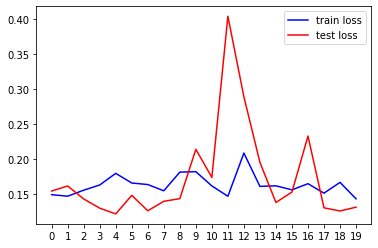

time:  448.3036904335022


In [85]:
from logging import exception
#Paramteres

#learning rate
lr = 1e-2

#number of training epochs
epoch_n = 20

#input image-mask size
image_size = 572
#root directory of project
root_dir = os.getcwd()

#training batch size
batch_size = 4

#use checkpoint model for training
load = False

#use GPU for training
gpu = True

data_dir = os.path.join(root_dir, 'data/cells')


trainset = Cell_data(data_dir = data_dir, size = image_size)
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)

testset = Cell_data(data_dir = data_dir, size = image_size, train = False)
testloader = DataLoader(testset, batch_size = batch_size)

device = torch.device('cuda:0' if gpu else 'cpu')

model = UNet().to('cuda:0').to(device)
# model = UNet().to(device)

if load:
  print('loading model')
  model.load_state_dict(torch.load('checkpoint.pt'))

criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=0.0005)

train_losses = []
test_losses = []
start = time.time()

#model.train()
for e in range(epoch_n):
  epoch_loss = 0
  model.train()
  for i, data in enumerate(trainloader):
    image, label = data
    
    #image = image.unsqueeze(1).to(device)
    image = image.to(device)
    label = label.long().to(device)

    #label = torch.argmax(label, dim=1)
    label = label.squeeze(1).to(device)

    pred = model(image)
    #print('shape1:')
    #print(pred.shape)

    crop_x = (label.shape[1] - pred.shape[2]) // 2
    crop_y = (label.shape[2] - pred.shape[3]) // 2

    label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]
    #print('shape:')
    #print(label.shape)
    
    loss = criterion(pred, label)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

    # print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))
  print('Epoch %d / %d --- Loss: %.4f' % (e + 1, epoch_n, epoch_loss / trainset.__len__()))

  train_losses.append(epoch_loss / trainset.__len__());

  torch.save(model.state_dict(), 'checkpoint.pt')

  model.eval()

  total = 0
  correct = 0
  total_loss = 0

  with torch.no_grad():
    for i, data in enumerate(testloader):
      image, label = data
      
      #image = image.unsqueeze(1).to(device)
      image = image.to(device)
      label = label.long().to(device)

      #label = torch.argmax(label, dim=1)
      label = label.squeeze(1).to(device)

      # plt.figure(0)
      # plt.imshow(image.squeeze(0).squeeze(0).cpu().numpy())
      # plt.figure(1)
      # plt.imshow(label.squeeze(0).cpu().numpy())

      # raise Exception

      pred = model(image)
      crop_x = (label.shape[1] - pred.shape[2]) // 2
      crop_y = (label.shape[2] - pred.shape[3]) // 2

      label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]

      loss = criterion(pred, label)
      total_loss += loss.item()

      _, pred_labels = torch.max(pred, dim = 1)

      total += label.shape[0] * label.shape[1] * label.shape[2]
      correct += (pred_labels == label).sum().item()

    print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))
    
  test_losses.append(total_loss / testset.__len__())
plt.plot(train_losses, color='b', label = 'train loss')
plt.plot(test_losses, color='r', label = 'test loss')
plt.legend()
plt.xticks(np.arange(epoch_n))
plt.show()

end = time.time()
print('time: ', end - start)


    



#Testing and Visualization

In [86]:
model.eval()


output_masks = []
output_labels = []

with torch.no_grad():
  for i in range(testset.__len__()):
    image, labels = testset.__getitem__(i)
    
    #input_image = image.unsqueeze(0).unsqueeze(0).to(device)
    input_image = image.unsqueeze(0).to(device)
    pred = model(input_image)

    #print(pred.shape, "pred")

    labels = labels.squeeze(0)

    #print(labels.shape, "labels")

    output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()

    crop_x = (labels.shape[0] - output_mask.shape[0]) // 2
    crop_y = (labels.shape[1] - output_mask.shape[1]) // 2
    labels = labels[crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].numpy()

    # print(labels, "labels")
    # print(output_mask, "om")
    
    output_masks.append(output_mask)
    output_labels.append(labels)


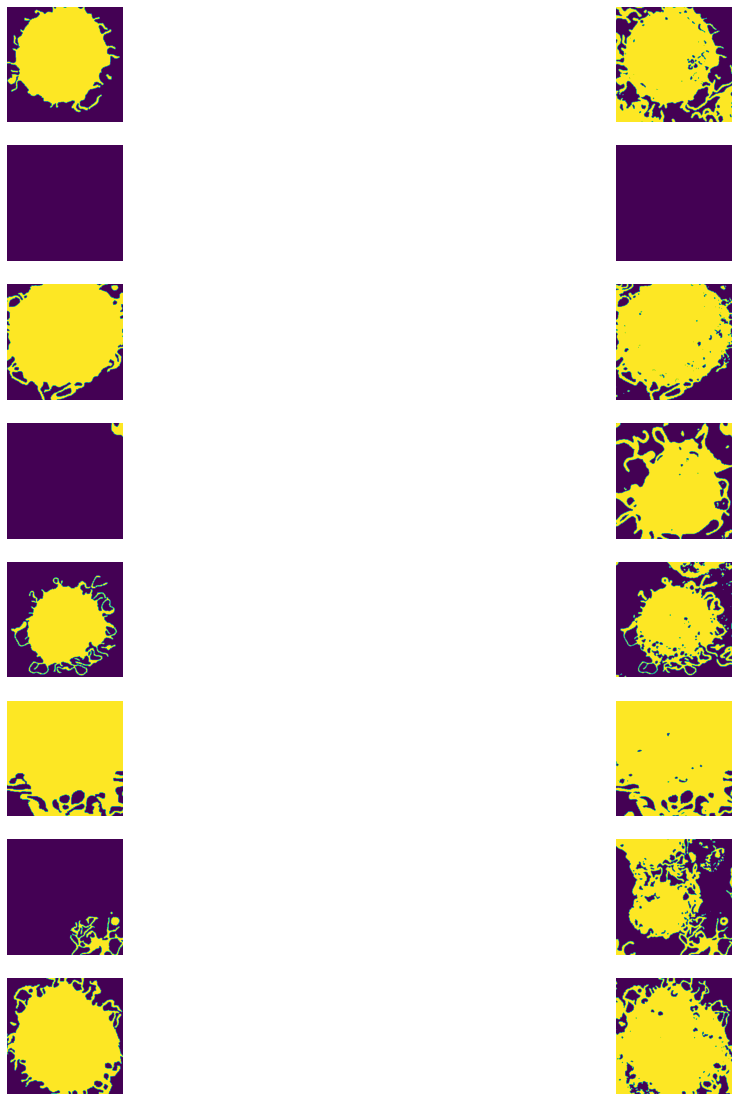

In [87]:
fig, axes = plt.subplots(testset.__len__(), 2, figsize = (20, 20))

for i in range(testset.__len__()):
  axes[i, 0].imshow(output_labels[i])
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_masks[i])
  axes[i, 1].axis('off')